In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

#import numpy as np # linear algebra
#import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
    #for filename in filenames:
        #print(os.path.join(dirname, filename))
    

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/UBC-OCEAN
/kaggle/input/UBC-OCEAN/test_thumbnails
/kaggle/input/UBC-OCEAN/train_images
/kaggle/input/UBC-OCEAN/train_thumbnails
/kaggle/input/UBC-OCEAN/test_images


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from PIL import Image
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_csv = pd.read_csv("/kaggle/input/UBC-OCEAN/train.csv")
test_csv = pd.read_csv("/kaggle/input/UBC-OCEAN/test.csv")
print(train_csv.shape, test_csv.shape)

(538, 5) (1, 3)


In [4]:
train_csv.sample(10)

,image_id,label,image_width,image_height,is_tma
475,56861,CC,45535,47147,False
157,18607,EC,44671,32875,False
325,38849,LGSC,60283,28011,False
520,63289,CC,32380,35307,False
317,38349,CC,45540,42755,False
504,61100,LGSC,40209,19886,False
57,6281,EC,75116,48293,False
490,59031,HGSC,48866,47340,False
338,39425,HGSC,68946,41260,False
182,21445,MC,34200,23705,False


In [5]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image_id      538 non-null    int64 
 1   label         538 non-null    object
 2   image_width   538 non-null    int64 
 3   image_height  538 non-null    int64 
 4   is_tma        538 non-null    bool  
dtypes: bool(1), int64(3), object(1)
memory usage: 17.5+ KB


In [6]:
fig = px.bar(train_csv, x='label')
fig.show()

In [7]:
train_csv['label'].value_counts()

label
HGSC    222
EC      124
CC       99
LGSC     47
MC       46
Name: count, dtype: int64

In [8]:
label_counts = train_csv['label'].value_counts()
fig = px.pie(label_counts, values=label_counts.values, names=label_counts.index)
fig.show()

In [9]:
is_tma_counts = train_csv['is_tma'].value_counts()
fig = px.pie(is_tma_counts, values=is_tma_counts.values, names=is_tma_counts.index)
fig.update_layout(title="Image Distributions on Train Data")
fig.show()

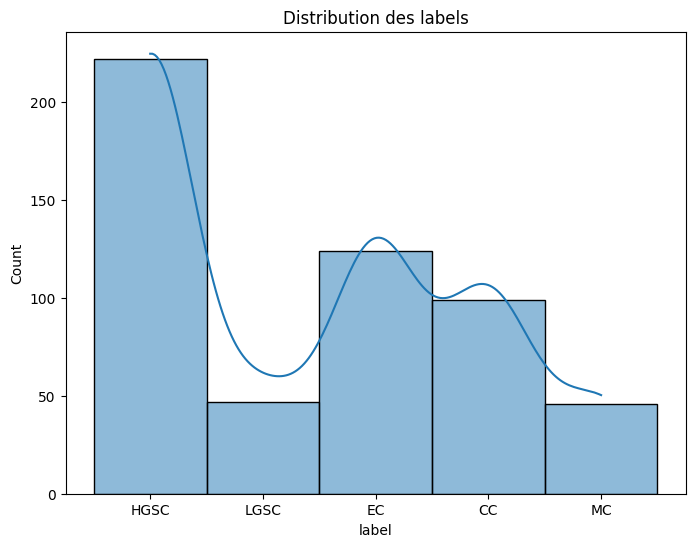

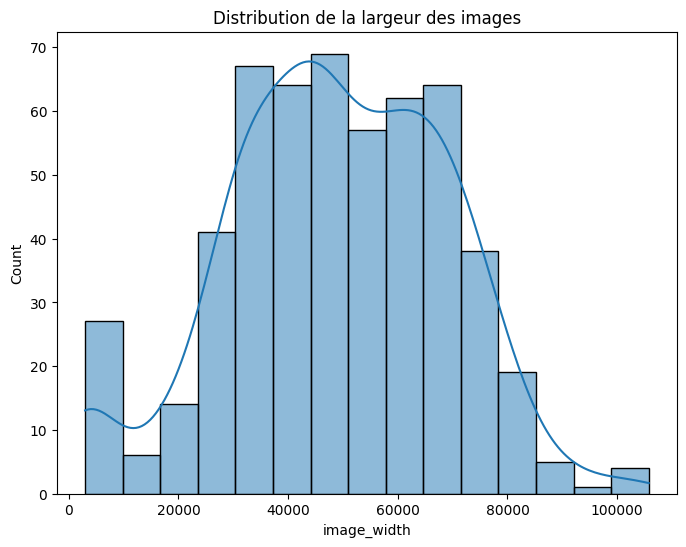

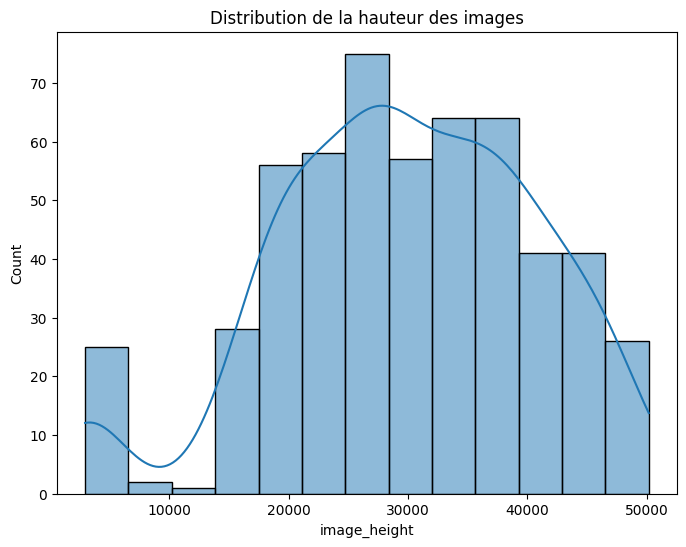

In [10]:
plt.figure(figsize=(8, 6))
sns.histplot(data=train_csv, x='label', kde=True)
plt.title('Distribution des labels')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(data=train_csv, x='image_width', kde=True)
plt.title('Distribution de la largeur des images')
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(data=train_csv, x='image_height', kde=True)
plt.title('Distribution de la hauteur des images')
plt.show()

In [11]:
Image.MAX_IMAGE_PIXELS = 10000000000

images_data = []
images_label = []

for img_id, label, tma in zip(train_csv['image_id'],train_csv['label'] ,train_csv['is_tma']):
    #print(img_id, label,  tma)
    if not tma:
        img_name = str(img_id)+"_thumbnail.png"
        image = Image.open("/kaggle/input/UBC-OCEAN/train_thumbnails/"+img_name)
        image = image.resize((512,512))
        image = np.array(image)
        images_data.append(image)
        images_label.append(label)
        
        
    elif tma:
        img_name = str(img_id)+".png"
        image = Image.open("/kaggle/input/UBC-OCEAN/train_images/"+img_name)
        image = image.resize((512,512))
        image = np.array(image)
        images_data.append(image)
        images_label.append(label)

X = np.array(images_data)
labels = np.array(images_label)
X.shape, labels.shape

((538, 512, 512, 3), (538,))

Text(0.5, 1.0, 'HGSC')

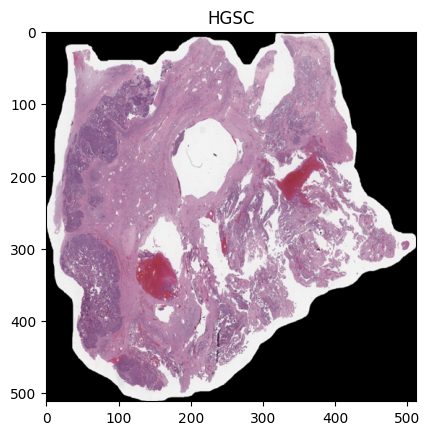

In [12]:
plt.imshow(X[0])
plt.title(labels[0])

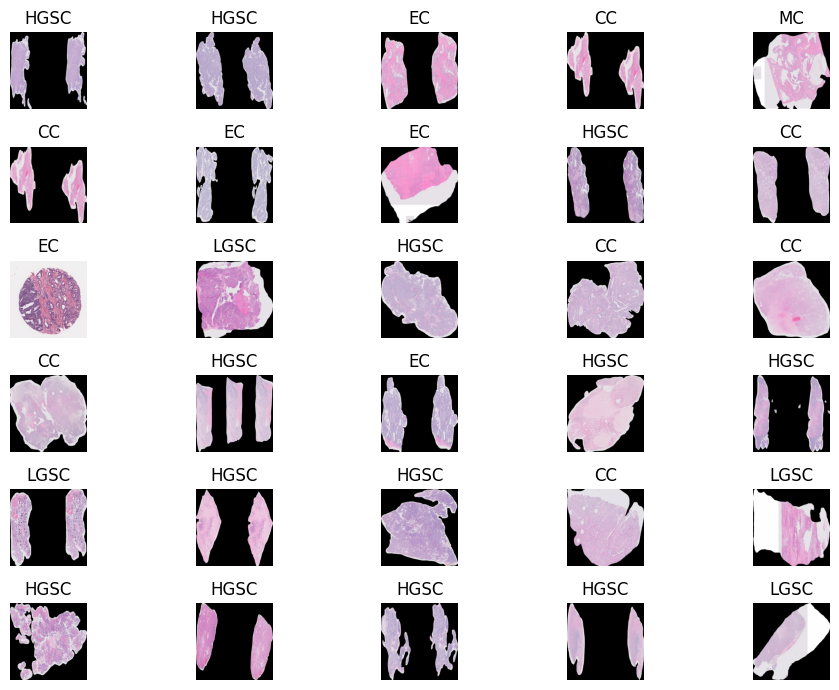

In [13]:
n_row = 6
n_col = 5
plt.figure(figsize=(10, 7))
for i in range(n_row*n_col):
    idx = np.random.randint(538)
    plt.subplot(n_row, n_col,i+1)
    plt.imshow(X[idx])
    plt.title(labels[idx])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
classes = {
    'CC' : 0, 'EC' : 1, 'HGSC' : 2, 'LGSC' : 3, 'MC' : 4
}

Y = []
for elt in labels:
    Y.append(classes[elt])
Y = np.array(Y)
Y.shape, Y[0], labels[0]

((538,), 2, 'HGSC')

In [15]:
np.unique(Y)

array([0, 1, 2, 3, 4])

In [16]:
num_c = 5
y = keras.utils.to_categorical(
    Y, num_classes=5
)

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0,stratify=y)

In [17]:
print(f"X_train shape : {x_train.shape}\ny_train shape : {y_train.shape}")

X_train shape : (430, 512, 512, 3)
y_train shape : (430, 5)


In [18]:
y_train[:10]

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [19]:
x_train_scaled = x_train/255
x_val_scaled = x_val/255

# Model

In [20]:
url1 = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/classification/2"
url2 = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/classification/2"

model_hub = hub.KerasLayer(url2,  input_shape=(512,512,3), trainable=False)

num_class = 5
model = keras.models.Sequential()
model.add(model_hub)
#model.add(keras.layers.Dense(64,activation='relu'))
#model.add(keras.layers.Dropout(0.2))
#model.add(keras.layers.Dense(32,activation='relu'))
#model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(units=num_class, activation="softmax"))


model.compile(optimizer="adam",loss="categorical_crossentropy",
             metrics=["accuracy"])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1000)              208896832 
                                                                 
 dense (Dense)               (None, 5)                 5005      
                                                                 
Total params: 208,901,837
Trainable params: 5,005
Non-trainable params: 208,896,832
_________________________________________________________________


In [21]:
data_generator = ImageDataGenerator(
    rotation_range=10, 
    width_shift_range=0.1,  
    height_shift_range=0.1, 
    zoom_range=0.1,  
    horizontal_flip=True 
)
augmented_data_generator = data_generator.flow(x_train_scaled, y_train, batch_size=16)

In [22]:
history = model.fit(augmented_data_generator,epochs=20, validation_data=(x_val_scaled,y_val))

Epoch 1/20
27/27 [==============================] - 101s 2s/step - loss: 2.0333 - accuracy: 0.3070 - val_loss: 1.7824 - val_accuracy: 0.2315
Epoch 2/20
27/27 [==============================] - 41s 1s/step - loss: 1.4524 - accuracy: 0.4302 - val_loss: 1.6079 - val_accuracy: 0.3519
Epoch 3/20
27/27 [==============================] - 41s 2s/step - loss: 1.2612 - accuracy: 0.4698 - val_loss: 1.4109 - val_accuracy: 0.4074
Epoch 4/20
27/27 [==============================] - 42s 2s/step - loss: 1.1434 - accuracy: 0.5488 - val_loss: 1.4056 - val_accuracy: 0.4352
Epoch 5/20
27/27 [==============================] - 42s 2s/step - loss: 1.0788 - accuracy: 0.5744 - val_loss: 1.4388 - val_accuracy: 0.4352
Epoch 6/20
27/27 [==============================] - 43s 2s/step - loss: 1.0915 - accuracy: 0.5744 - val_loss: 1.3704 - val_accuracy: 0.4259
Epoch 7/20
27/27 [==============================] - 43s 2s/step - loss: 0.9566 - accuracy: 0.6209 - val_loss: 1.3669 - val_accuracy: 0.4352
Epoch 8/20
27/27 [=